# Fake news detection
## Logistic regression with feature extraction

### Setup

In [1]:
import pandas as pd
import numpy as np
import string
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist

from sklearn import linear_model, metrics
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import f1_score, accuracy_score

from wordcloud import WordCloud, STOPWORDS

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Feature engineering

In [2]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

train.columns = ["text", "label"]
test.columns = ["label", "text"]

train = train[train['label'] != "Label"]
test = test[test['label'] != "Label"]

In [3]:
print(train.shape)
print(test.shape)

(79522, 2)
(7011, 2)


In [4]:
train.head()

,text,label
0,Report: War Looms - Hundreds of American Troop...,0
1,I walked through a preview of the artist Pedro...,1
2,Neo-Con Hypocrites Leverage Human Rights Again...,0
3,"A giant beef roast for the holidays is, for ma...",1
4,Seeking to appeal to guestsâ€™ desire for new ...,1


In [5]:
# Remove non-ACSII characters

train["text"] = train["text"].apply(lambda x: x.encode("ascii", errors="ignore").decode())
test["text"] = test["text"].apply(lambda x: x.encode("ascii", errors="ignore").decode())

In [6]:
# Calculate text length

train["text_length"] = train["text"].apply(lambda x: len(x))
test["text_length"] = test["text"].apply(lambda x: len(x))

train.head()

,text,label,text_length
0,Report: War Looms - Hundreds of American Troop...,0,3940
1,I walked through a preview of the artist Pedro...,1,6707
2,Neo-Con Hypocrites Leverage Human Rights Again...,0,3443
3,"A giant beef roast for the holidays is, for ma...",1,3365
4,Seeking to appeal to guests desire for new exp...,1,5574


In [7]:
# Calculate number of sentences

train['num_sentences'] = train['text'].apply(lambda x: len(sent_tokenize(x)))
test['num_sentences'] = test['text'].apply(lambda x: len(sent_tokenize(x)))

In [8]:
# Count number of exclamation and question marks

train["num_exclamation"] = train["text"].apply(lambda x: x.count("!"))
test["num_exclamation"] = test["text"].apply(lambda x: x.count("!"))

train["num_question"] = train["text"].apply(lambda x: x.count("?"))
test["num_question"] = test["text"].apply(lambda x: x.count("?"))

In [9]:
# Remove symbols and punctuations

def remove_symbols(text):
    clean = re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', '', text)
    return clean

def remove_punctuation(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [10]:
train['text'] = train['text'].apply(lambda x: remove_symbols(x))
test['text'] = test['text'].apply(lambda x: remove_symbols(x))

train['text'] = train['text'].apply(lambda x: remove_punctuation(x))
test['text'] = test['text'].apply(lambda x: remove_punctuation(x))

train['tokenized_text'] = train['text'].apply(word_tokenize)
test['tokenized_text'] = test['text'].apply(word_tokenize)

In [11]:
train.head()

,text,label,text_length,num_sentences,num_exclamation,num_question,tokenized_text
0,Report War Looms Hundreds of American Troops ...,0,3940,26,0,2,"[Report, War, Looms, Hundreds, of, American, T..."
1,I walked through a preview of the artist Pedro...,1,6707,52,1,0,"[I, walked, through, a, preview, of, the, arti..."
2,NeoCon Hypocrites Leverage Human Rights Agains...,0,3443,15,0,0,"[NeoCon, Hypocrites, Leverage, Human, Rights, ..."
3,A giant beef roast for the holidays is for man...,1,3365,32,0,2,"[A, giant, beef, roast, for, the, holidays, is..."
4,Seeking to appeal to guests desire for new exp...,1,5574,20,0,0,"[Seeking, to, appeal, to, guests, desire, for,..."


In [12]:
# Calculate number of words

train["num_words"] = train["tokenized_text"].apply(lambda x: len(x))
test["num_words"] = test["tokenized_text"].apply(lambda x: len(x))

In [13]:
# Calculate average word and sentence length

train['avg_word_len'] = train['tokenized_text'].apply(lambda x: sum([len(word) for word in x])/len(x))
test['avg_word_len'] = test['tokenized_text'].apply(lambda x: sum([len(word) for word in x])/len(x))

train['avg_sent_len'] = train['num_words'] / train['num_sentences']
test['avg_sent_len'] = test['num_words'] / test['num_sentences']

In [14]:
train['tokenized_text'] = train['tokenized_text'].apply(lambda x: [word.lower() for word in x])
test['tokenized_text'] = test['tokenized_text'].apply(lambda x: [word.lower() for word in x])

stop = set(stopwords.words('english'))

train['stopwords_removed_text'] = train['tokenized_text'].apply(lambda x: [word for word in x if word not in stop])
test['stopwords_removed_text'] = test['tokenized_text'].apply(lambda x: [word for word in x if word not in stop])

In [15]:
train.head()

,text,label,text_length,num_sentences,num_exclamation,num_question,tokenized_text,num_words,avg_word_len,avg_sent_len,stopwords_removed_text
0,Report War Looms Hundreds of American Troops ...,0,3940,26,0,2,"[report, war, looms, hundreds, of, american, t...",637,5.062794,24.500000,"[report, war, looms, hundreds, american, troop..."
1,I walked through a preview of the artist Pedro...,1,6707,52,1,0,"[i, walked, through, a, preview, of, the, arti...",1150,4.643478,22.115385,"[walked, preview, artist, pedro, reyess, creat..."
2,NeoCon Hypocrites Leverage Human Rights Agains...,0,3443,15,0,0,"[neocon, hypocrites, leverage, human, rights, ...",529,5.398866,35.266667,"[neocon, hypocrites, leverage, human, rights, ..."
3,A giant beef roast for the holidays is for man...,1,3365,32,0,2,"[a, giant, beef, roast, for, the, holidays, is...",576,4.631944,18.000000,"[giant, beef, roast, holidays, many, de, rigue..."
4,Seeking to appeal to guests desire for new exp...,1,5574,20,0,0,"[seeking, to, appeal, to, guests, desire, for,...",919,4.937976,45.950000,"[seeking, appeal, guests, desire, new, experie..."


In [16]:
train['pos_tags'] = train['stopwords_removed_text'].apply(nltk.tag.pos_tag)
test['pos_tags'] = test['stopwords_removed_text'].apply(nltk.tag.pos_tag)

In [17]:
# Determine parts of speech

def part_of_speech(tag):
    if tag.startswith('J'):
        return "adj"
    elif tag.startswith('V'):
        return "verb"
    elif tag.startswith('N'):
        return "noun"
    elif tag.startswith('R'):
        return "adv"
    else:
        return "noun"

train['pos'] = train['pos_tags'].apply(lambda x: [part_of_speech(pos_tag) for (word, pos_tag) in x])
test['pos'] = test['pos_tags'].apply(lambda x: [part_of_speech(pos_tag) for (word, pos_tag) in x])

In [18]:
# Calculate proportion of nouns, verbs and adjectives

train["pct_noun"] = train["pos"].apply(lambda x: x.count("noun") / len(x) if len(x) != 0 else 0)
test["pct_noun"] = test["pos"].apply(lambda x: x.count("noun") / len(x) if len(x) != 0 else 0)

train["pct_verb"] = train["pos"].apply(lambda x: x.count("verb") / len(x) if len(x) != 0 else 0)
test["pct_verb"] = test["pos"].apply(lambda x: x.count("verb") / len(x) if len(x) != 0 else 0)

train["pct_adj"] = train["pos"].apply(lambda x: x.count("adj") / len(x) if len(x) != 0 else 0)
test["pct_adj"] = test["pos"].apply(lambda x: x.count("adj") / len(x) if len(x) != 0 else 0)

train.head()

,text,label,text_length,num_sentences,num_exclamation,num_question,tokenized_text,num_words,avg_word_len,avg_sent_len,stopwords_removed_text,pos_tags,pos,pct_noun,pct_verb,pct_adj
0,Report War Looms Hundreds of American Troops ...,0,3940,26,0,2,"[report, war, looms, hundreds, of, american, t...",637,5.062794,24.500000,"[report, war, looms, hundreds, american, troop...","[(report, NN), (war, NN), (looms, VBZ), (hundr...","[noun, noun, verb, noun, adj, noun, verb, noun...",0.489247,0.223118,0.212366
1,I walked through a preview of the artist Pedro...,1,6707,52,1,0,"[i, walked, through, a, preview, of, the, arti...",1150,4.643478,22.115385,"[walked, preview, artist, pedro, reyess, creat...","[(walked, VBN), (preview, JJ), (artist, NN), (...","[verb, adj, noun, noun, verb, adj, noun, noun,...",0.521545,0.200594,0.199108
2,NeoCon Hypocrites Leverage Human Rights Agains...,0,3443,15,0,0,"[neocon, hypocrites, leverage, human, rights, ...",529,5.398866,35.266667,"[neocon, hypocrites, leverage, human, rights, ...","[(neocon, NN), (hypocrites, VBZ), (leverage, J...","[noun, verb, adj, adj, noun, noun, noun, noun,...",0.478261,0.257764,0.164596
3,A giant beef roast for the holidays is for man...,1,3365,32,0,2,"[a, giant, beef, roast, for, the, holidays, is...",576,4.631944,18.000000,"[giant, beef, roast, holidays, many, de, rigue...","[(giant, JJ), (beef, NN), (roast, NN), (holida...","[adj, noun, noun, verb, adj, noun, noun, verb,...",0.517751,0.162722,0.254438
4,Seeking to appeal to guests desire for new exp...,1,5574,20,0,0,"[seeking, to, appeal, to, guests, desire, for,...",919,4.937976,45.950000,"[seeking, appeal, guests, desire, new, experie...","[(seeking, VBG), (appeal, NN), (guests, NNS), ...","[verb, noun, noun, verb, adj, noun, verb, adj,...",0.544803,0.224014,0.195341


In [19]:
train["pct_exclamation"] = train["num_exclamation"] / train["text_length"]
test["pct_exclamation"] = test["num_exclamation"] / test["text_length"]

train["pct_question"] = train["num_question"] / train["text_length"]
test["pct_question"] = test["num_question"] / test["text_length"]

train["adj"] = train["pos"].apply(lambda x: x.count("adj"))
test["adj"] = test["pos"].apply(lambda x: x.count("adj"))

train["verb"] = train["pos"].apply(lambda x: x.count("verb"))
test["verb"] = test["pos"].apply(lambda x: x.count("verb"))

train["noun"] = train["pos"].apply(lambda x: x.count("noun"))
test["noun"] = test["pos"].apply(lambda x: x.count("noun"))

In [20]:
# Save preprocessed text

train.to_csv("data/train_preprocessed.csv")
test.to_csv("data/test_preprocessed.csv")

### Visualisations

In [21]:
train = pd.read_csv("data/train_preprocessed.csv")
test = pd.read_csv("data/test_preprocessed.csv")

train.head()

,Unnamed: 0,text,label,text_length,num_sentences,num_exclamation,num_question,tokenized_text,num_words,avg_word_len,...,pos_tags,pos,pct_noun,pct_verb,pct_adj,pct_exclamation,pct_question,adj,verb,noun
0,0,Report War Looms Hundreds of American Troops ...,0,3940,26,0,2,"['report', 'war', 'looms', 'hundreds', 'of', '...",637,5.062794,...,"[('report', 'NN'), ('war', 'NN'), ('looms', 'V...","['noun', 'noun', 'verb', 'noun', 'adj', 'noun'...",0.489247,0.223118,0.212366,0.000000,0.000508,79,83,182
1,1,I walked through a preview of the artist Pedro...,1,6707,52,1,0,"['i', 'walked', 'through', 'a', 'preview', 'of...",1150,4.643478,...,"[('walked', 'VBN'), ('preview', 'JJ'), ('artis...","['verb', 'adj', 'noun', 'noun', 'verb', 'adj',...",0.521545,0.200594,0.199108,0.000149,0.000000,134,135,351
2,2,NeoCon Hypocrites Leverage Human Rights Agains...,0,3443,15,0,0,"['neocon', 'hypocrites', 'leverage', 'human', ...",529,5.398866,...,"[('neocon', 'NN'), ('hypocrites', 'VBZ'), ('le...","['noun', 'verb', 'adj', 'adj', 'noun', 'noun',...",0.478261,0.257764,0.164596,0.000000,0.000000,53,83,154
3,3,A giant beef roast for the holidays is for man...,1,3365,32,0,2,"['a', 'giant', 'beef', 'roast', 'for', 'the', ...",576,4.631944,...,"[('giant', 'JJ'), ('beef', 'NN'), ('roast', 'N...","['adj', 'noun', 'noun', 'verb', 'adj', 'noun',...",0.517751,0.162722,0.254438,0.000000,0.000594,86,55,175
4,4,Seeking to appeal to guests desire for new exp...,1,5574,20,0,0,"['seeking', 'to', 'appeal', 'to', 'guests', 'd...",919,4.937976,...,"[('seeking', 'VBG'), ('appeal', 'NN'), ('guest...","['verb', 'noun', 'noun', 'verb', 'adj', 'noun'...",0.544803,0.224014,0.195341,0.000000,0.000000,109,125,304


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib.ticker import MaxNLocator

In [23]:
def plot_dist(df, feature, title, bins):
    fig = plt.figure(constrained_layout=True, figsize=(18, 10))
    grid = gridspec.GridSpec(ncols= 2,nrows=2, figure=fig)

    ax1 = fig.add_subplot(grid[0, 0])

    ax1.set_title('Histogram')
    sns.distplot(df[df['label'] == 0].loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,)
    sns.distplot(df[df['label'] == 1].loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,)
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=bins))

    ax3 = fig.add_subplot(grid[0, 1])
    ax3.set_title('Box Plot')
    sns.boxplot(x= 'label', y=feature, data=df, ax=ax3)
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=bins))

    plt.suptitle(f'{title}', fontsize=24)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


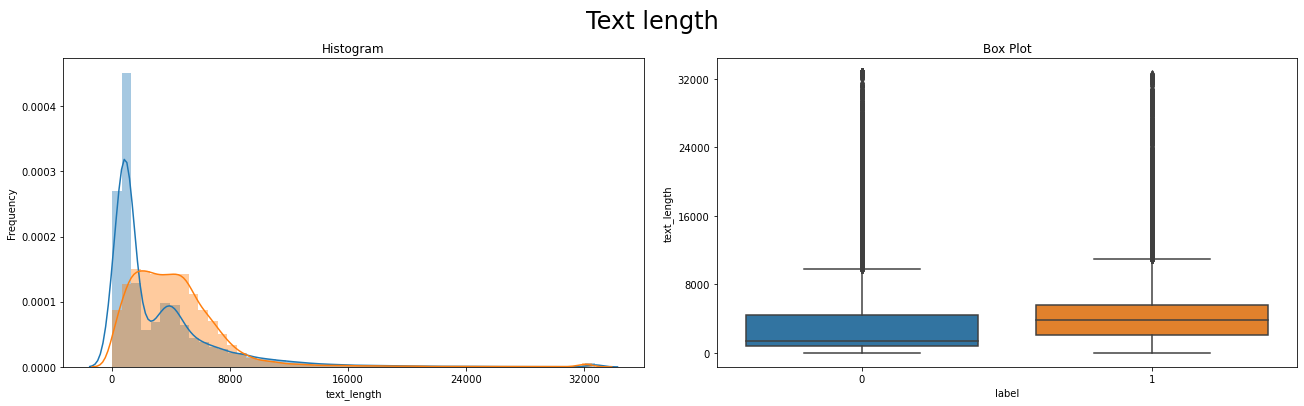

In [24]:
# Text length

plot_dist(train, 'text_length', 'Text length', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


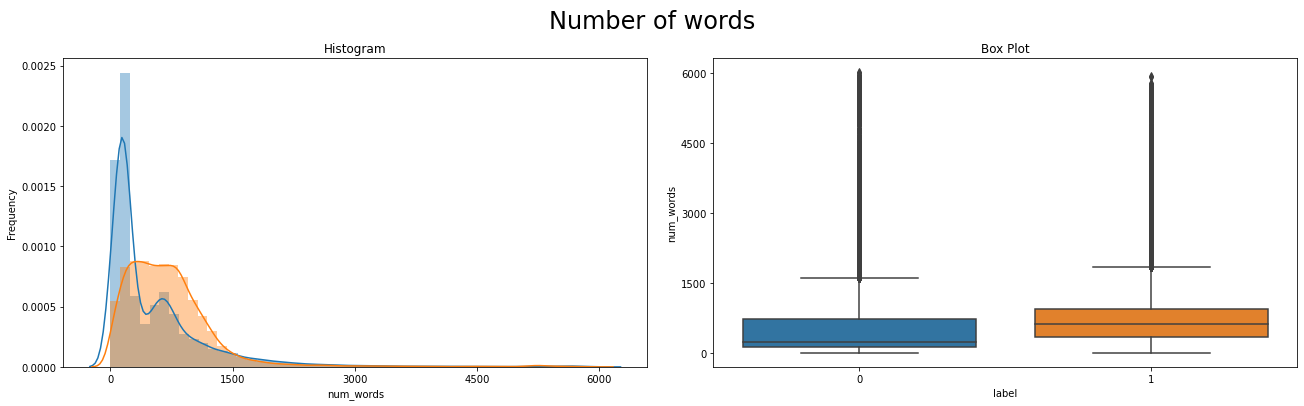

In [25]:
# Number of words

plot_dist(train, 'num_words', 'Number of words', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


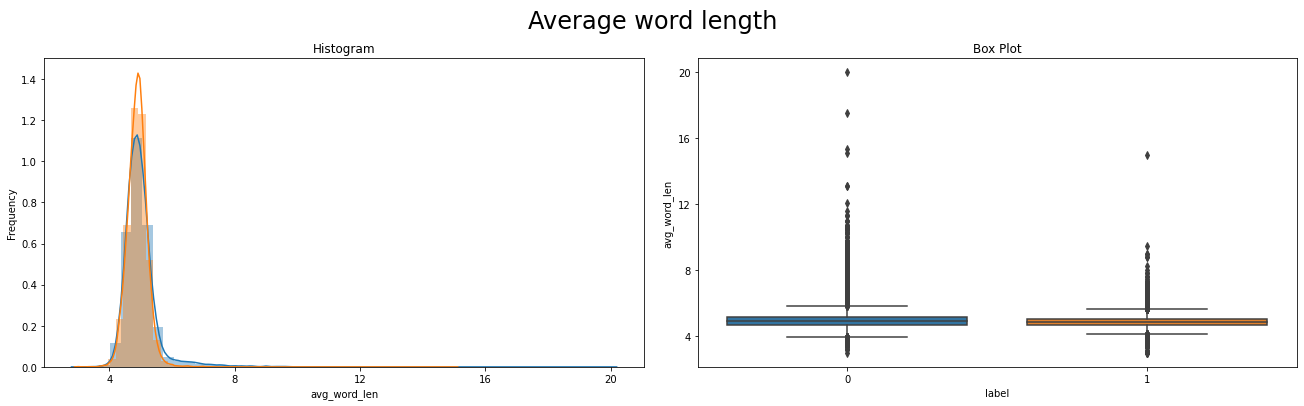

In [26]:
# Average word length

plot_dist(train, 'avg_word_len', 'Average word length', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


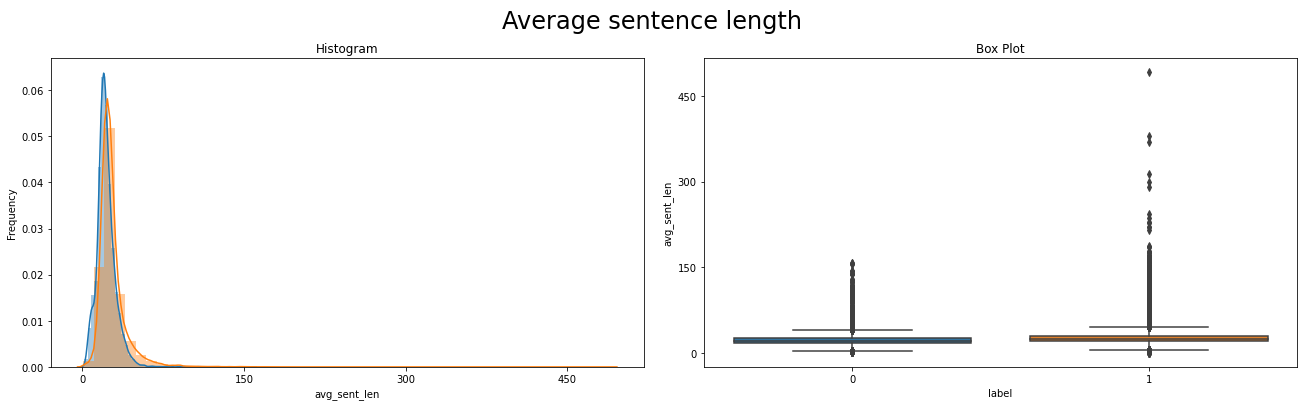

In [27]:
# Average sentence length

plot_dist(train, 'avg_sent_len', 'Average sentence length', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


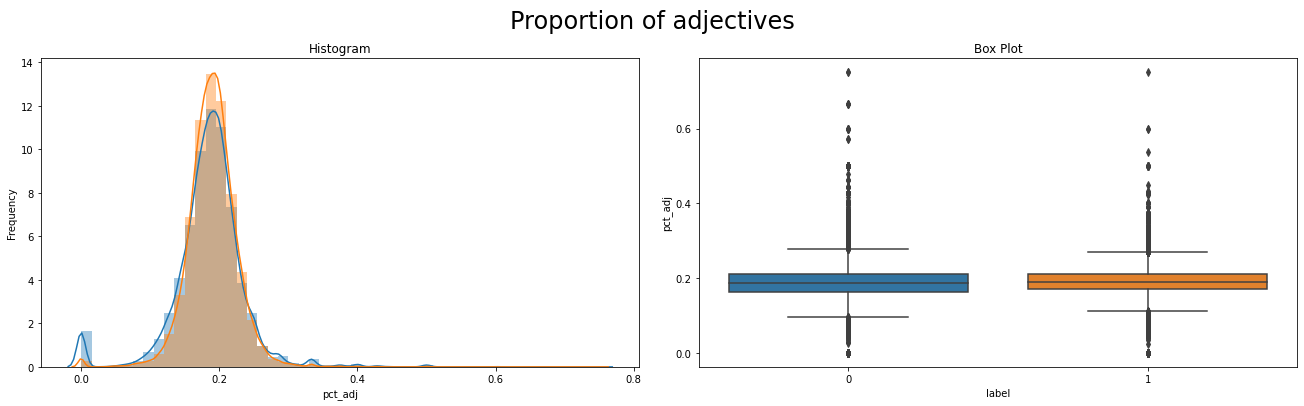

In [28]:
# Adjectives

plot_dist(train, 'pct_adj', 'Proportion of adjectives', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


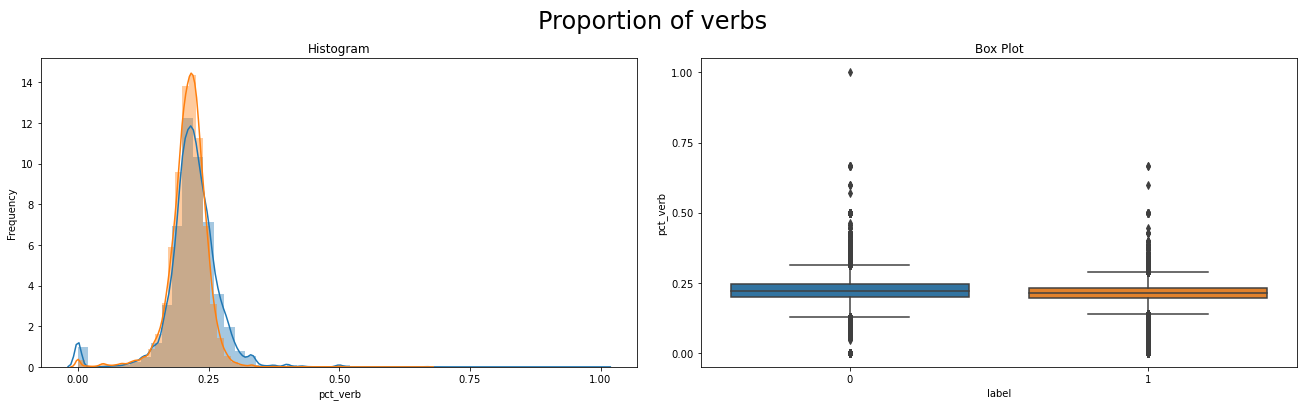

In [29]:
# Verb

plot_dist(train, 'pct_verb', 'Proportion of verbs', 5)

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


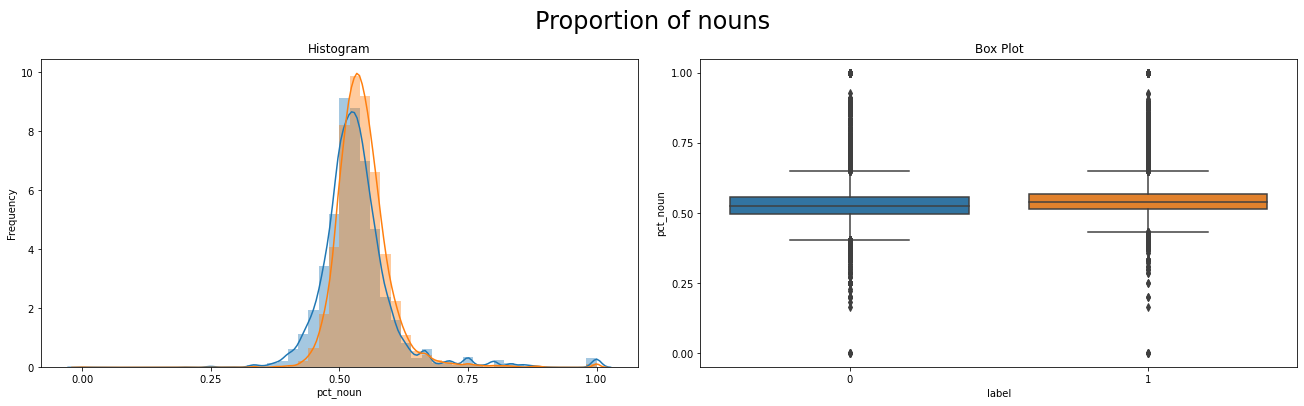

In [30]:
# Noun

plot_dist(train, 'pct_noun', 'Proportion of nouns', 5)

### Logistic Regression Model

In [31]:
labels = ["pct_verb", "pct_adj", "pct_question", "pct_exclamation", "avg_word_len", "num_words"]

x_train = train[labels]
y_train = train["label"]
x_test = test[labels]
y_test = test["label"]

In [32]:
from sklearn import preprocessing
from sklearn.metrics import classification_report

ss = preprocessing.StandardScaler()
x_train = ss.fit_transform(x_train)
x_test = ss.transform(x_test)

In [33]:
logit = linear_model.LogisticRegression()
logit.fit(x_train, y_train)

y_pred = logit.predict(x_test)

print("Confusion matrix:")
print(metrics.confusion_matrix(y_test, y_pred))
print()

print("Score of logistic regression model:", logit.score(x_test, y_test))

print(classification_report(y_test, y_pred))

Confusion matrix:
[[1061 1181]
 [ 721 4048]]

Score of logistic regression model: 0.7287120239623449
              precision    recall  f1-score   support

           0       0.60      0.47      0.53      2242
           1       0.77      0.85      0.81      4769

    accuracy                           0.73      7011
   macro avg       0.68      0.66      0.67      7011
weighted avg       0.72      0.73      0.72      7011



Feature: 0, Score: -0.23661
Feature: 1, Score: 0.05941
Feature: 2, Score: -0.98805
Feature: 3, Score: -1.02203
Feature: 4, Score: -0.39037
Feature: 5, Score: 0.28624


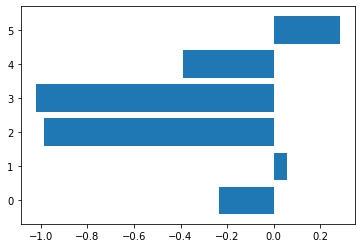

In [34]:
from matplotlib import pyplot

importance = logit.coef_[0]

# Summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

# Plot feature importance
pyplot.barh([x for x in range(len(importance))], importance)
pyplot.show()